In [17]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")
from PmtIDMap import PMTIDMap
map_pmt = PMTIDMap("/cvmfs/juno.ihep.ac.cn/centos7_amd64_gcc830/Pre-Release/J21v1r0-Pre2/offline/Simulation/DetSimV2/DetSimOptions/data/PMTPos_Acrylic_with_chimney.csv")
import os
from glob import glob
from LoadMultiFiles import LoadMultiROOTFiles
import ROOT
import root_numpy as rn

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [18]:
from copy import copy
dir_events_diff_options = {}
dir_path_input = {
    "full-simulation":"/afs/ihep.ac.cn/users/v/valprod0/Pre-Releases/J21v1r0-Pre2/11/ACU/Co60/Co60_0_0_0/calib/user-root/user-calib-*.root",
    "tau1=4.6,no-tts":"/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_no_tts/user-elec2rec-*.root",
    "tau1=4.6":"/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_tau1_4.6/user-elec2rec-*.root",
    "tau1=0.1":"/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_tau1_0.1/user-elec2rec-*.root",
    "tau1=0.1,no-tts":"/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_no_tts_tau1_0.1/user-elec2rec-*.root"
}

n_root_to_load = -1
for key, path_input in dir_path_input.items():
    list_name_branch_filter = ["Width","Peak","PMTID"]

    dir_events = LoadMultiROOTFiles(path_input, name_branch="calibevt", list_branch_filter=list_name_branch_filter,n_files_to_load=n_root_to_load)
    path_input = path_input.replace("calib", "recQTMLE") if key=="full-simulation" else path_input
    print(path_input)
    dir_events_rec = LoadMultiROOTFiles(path_input,  name_branch="TRec", n_files_to_load=n_root_to_load)
    dir_events["m_FadcEvtT"] = dir_events_rec["m_FadcEvtT"]
    dir_events_diff_options[key] = copy(dir_events)

/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/LoadMultiFiles.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dir_events[key] = np.array(dir_events[key])


/afs/ihep.ac.cn/users/v/valprod0/Pre-Releases/J21v1r0-Pre2/11/ACU/Co60/Co60_0_0_0/recQTMLE/user-root/user-recQTMLE-*.root
/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_no_tts/user-elec2rec-*.root
/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_tau1_4.6/user-elec2rec-*.root
/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_tau1_0.1/user-elec2rec-*.root
/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/user-root_no_tts_tau1_0.1/user-elec2rec-*.root


Text(0.5, 0, '$t_0$ [ ns ]')

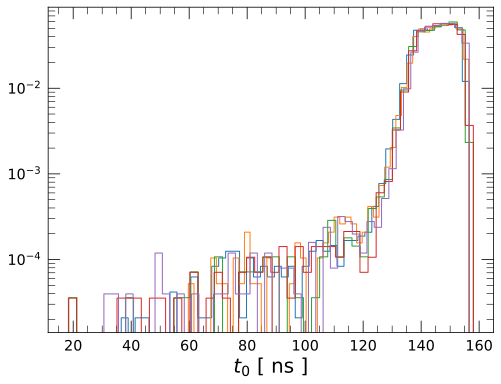

In [19]:
# Check t0 distribution
for key_option,dir_events in dir_events_diff_options.items():
    plt.hist(dir_events["m_FadcEvtT"], bins=50, histtype="step", density=True,label=key_option )
plt.semilogy()
plt.xlabel(r"$t_0$ [ ns ]")


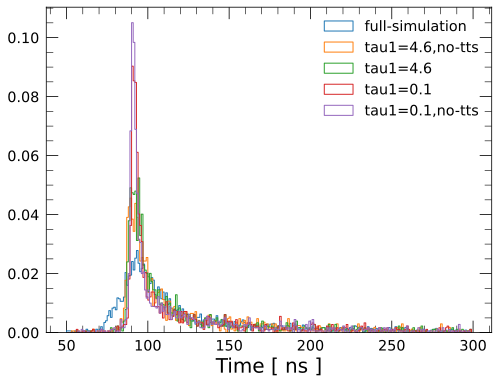

In [20]:
from HistTools import GetBinCenter
pmtid_certain = 1
dir_time_diff_options = {}
dit_hist_time_diff_option = {}
dir_max_h_time = {}
bins_time = np.arange(50, 300, 1)
for key, dir_events in dir_events_diff_options.items():
    v_time_certain_pmt = []
    for v_PMTID, v_time,t0 in zip(dir_events["SimplePMTID"], dir_events["Time"], dir_events["m_FadcEvtT"]):
        index_certain_pmt = (v_PMTID==pmtid_certain)
        if np.any(index_certain_pmt):
            v_time_certain_pmt.append(v_time[index_certain_pmt][0]-t0)
    hist = plt.hist(v_time_certain_pmt,bins=bins_time,histtype="step", density=True,
                    label=key)
    # plt.semilogy()
    plt.xlabel("Time [ ns ]")
    plt.legend()
    h_time_max = GetBinCenter(hist[1])[np.argmax(hist[0])]
    dir_time_diff_options[key] = np.array(v_time_certain_pmt)
    dit_hist_time_diff_option[key] = hist
    dir_max_h_time[key] = h_time_max

In [ ]:
time_max_cut = 200
x_max = time_max_cut
x_min = 50
dir_time_arrive_fit = {}
dir_time_arrive_sigma = {}

for i,key_option in enumerate(dir_time_diff_options.keys()):
    h_time_max = dir_max_h_time[key_option]
    v_time_certain_pmt = dir_time_diff_options[key_option]

    x = ROOT.RooRealVar("Time","Time",x_min,x_max)

    # Construct signal pdf
    mean = ROOT.RooRealVar("mean", "mean", h_time_max, x_min, x_max)

    if h_time_max <20:
        sigma = ROOT.RooRealVar("sigma", "sigma", 1, 0.1, 300)
    else:
        sigma = ROOT.RooRealVar("sigma", "sigma", 2, 0.1, 300)
    gx = ROOT.RooGaussian("gx", "gx", x, mean, sigma)
    # gx = ROOT.RooLandau("gx", "gx", x, mean, sigma)

    f = ROOT.RooRealVar("f", "f", 0.5, 0.0, 1.0)

    v_time = np.array(v_time_certain_pmt, dtype=[('Time',np.float32)])
    tree_time = rn.array2tree(v_time,name='HitTime')
    data = ROOT.RooDataSet("data","data",ROOT.RooArgSet(x), ROOT.RooFit.Import(tree_time))
    if "tau1=0.1" in key_option:
        x.setRange("signal", h_time_max-4, h_time_max+4)
    elif key_option == "full-simulation":
        x.setRange("signal", h_time_max-20, h_time_max+20)
    else:
        x.setRange("signal", h_time_max-10, h_time_max+10)

    fit_result = gx.fitTo(data, ROOT.RooFit.Range("signal"), ROOT.RooFit.Save())
    # print("Chi2:\t", fit_result.minNll())

    locals()[f"c{i}"] = ROOT.TCanvas(f"c_time_{i}","")
    xframe = x.frame()
    data.plotOn(xframe)
    gx.plotOn(xframe)
    gx.paramOn(xframe, ROOT.RooFit.Layout(0.6,0.9,0.9),ROOT.RooFit.ShowConstants(True))
    xframe.Draw()
    locals()[f"c{i}"].Draw()

    dir_time_arrive_fit[key_option] = mean.getVal(0)
    dir_time_arrive_sigma[key_option] = sigma.getVal(0)

In [ ]:
from HistTools import RedrawHistFrom_plt_hist
for key_option in dir_time_arrive_fit.keys():
    print(len(dir_time_diff_options[key_option]))
    RedrawHistFrom_plt_hist(dit_hist_time_diff_option[key_option],
                            label=f"{key_option} sigma={dir_time_arrive_sigma[key_option]:.1f}")
plt.xlim(50, 150)
plt.legend()
plt.xlabel("Time [ ns ]")
plt.savefig("/afs/ihep.ac.cn/users/l/luoxj/TOFCalibration/TurnoffEmissionTimeDelay/figure/diff_options_hist_time.png")